In [1510]:
# pip install git+https://github.com/pymc-labs/pymc-marketing.git

In [1511]:
import pandas as pd
import numpy as np
import datetime as dt
from pymc_marketing import clv
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
from arviz.labels import MapLabeller
import seaborn as sns
import missingno as msno

# Analisis exploratorio

In [1512]:
# Cargar datos
df = pd.read_csv('/kaggle/input/online-retail-dataset/online_retail.csv', encoding='unicode_escape')

In [1513]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [1514]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [1515]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


### Tenemos un gran numero de customers id faltantes

<Axes: >

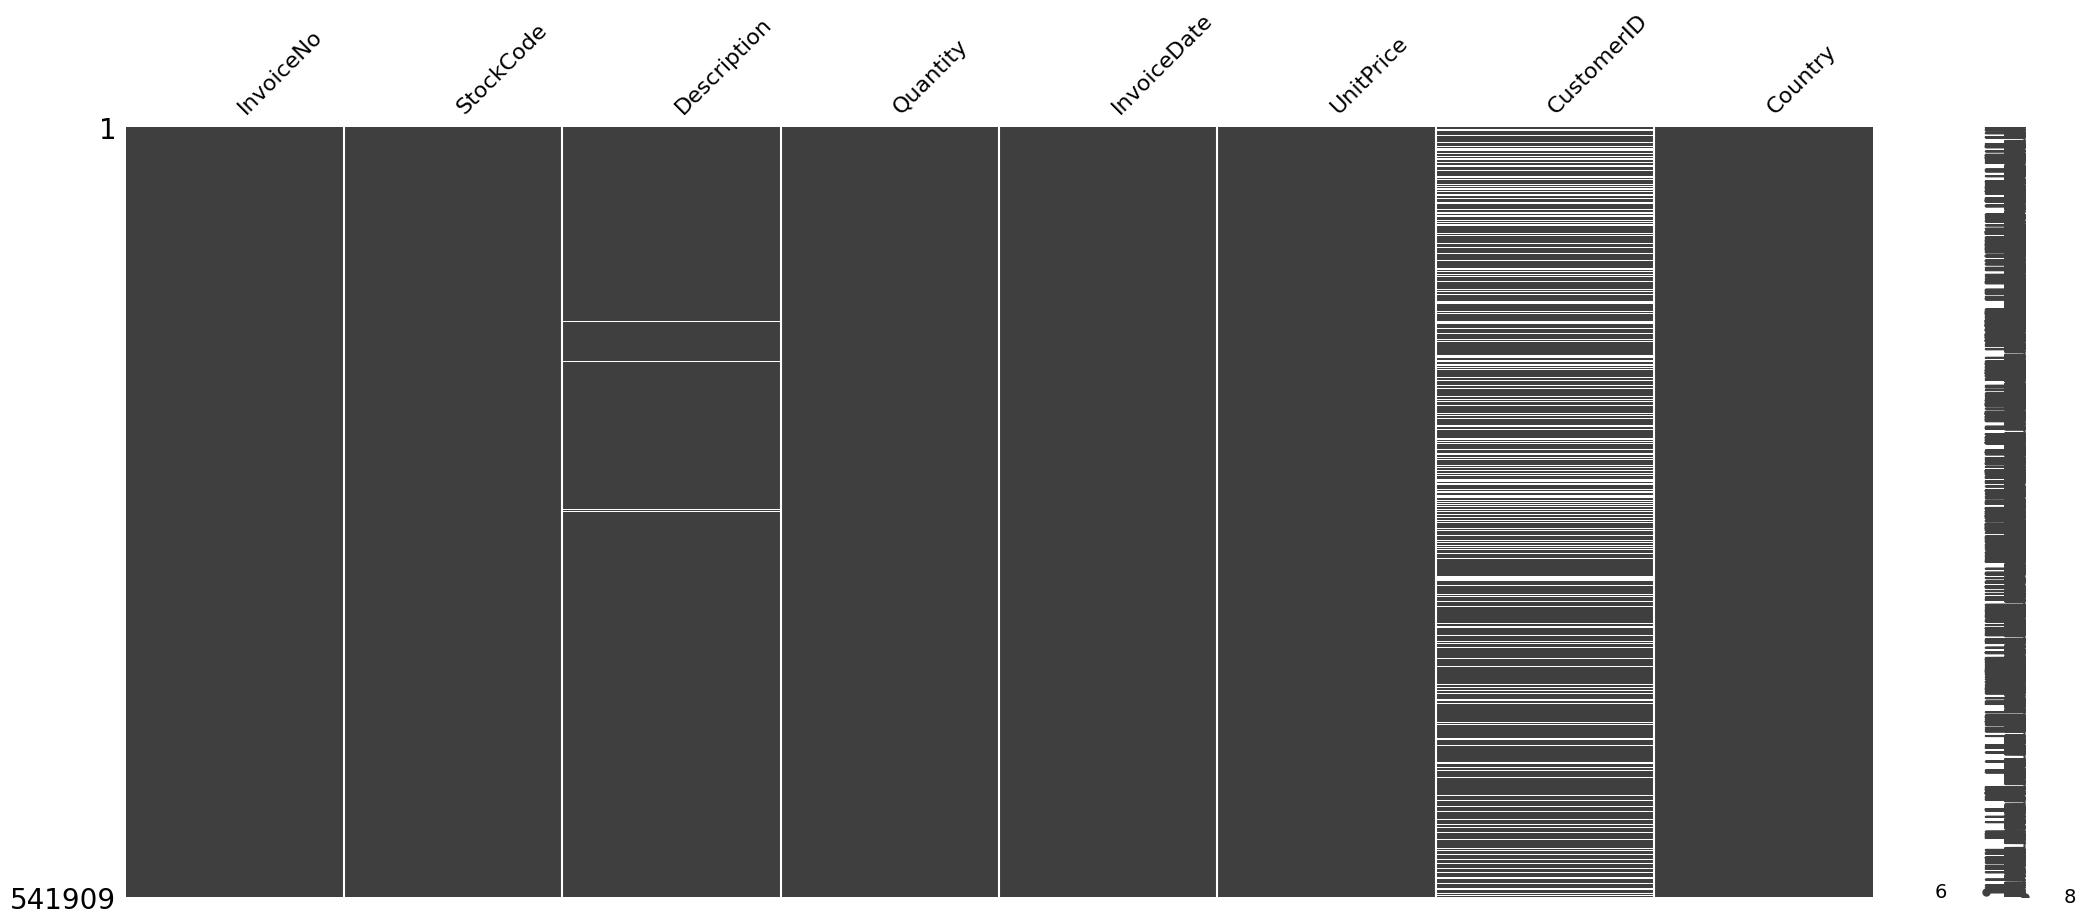

In [1516]:
msno.matrix(df)

In [1517]:
# Limpieza
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.dropna()
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['TotalCost'] = df['Quantity'] * df['UnitPrice']

## Distribucion de variables numericas

Tenemos distribuciones muy asimetricas

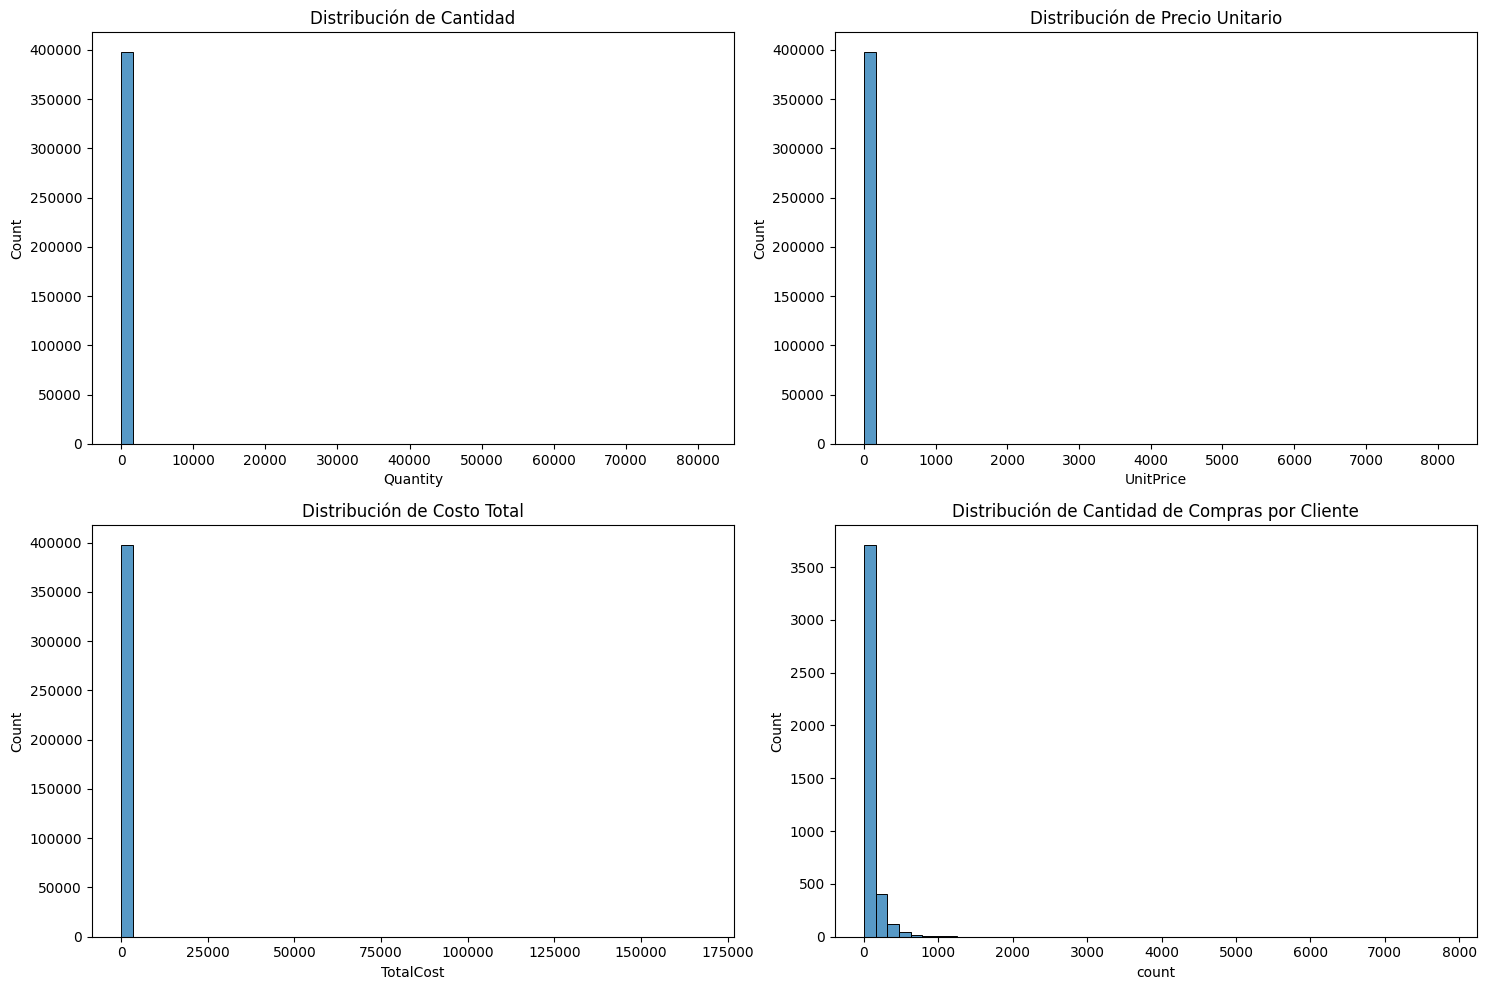

In [1518]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(df['Quantity'], bins=50)
plt.title('Distribución de Cantidad')
plt.subplot(2, 2, 2)
sns.histplot(df['UnitPrice'], bins=50)
plt.title('Distribución de Precio Unitario')
plt.subplot(2, 2, 3)
sns.histplot(df['TotalCost'], bins=50)
plt.title('Distribución de Costo Total')
plt.subplot(2, 2, 4)
sns.histplot(df['CustomerID'].value_counts(), bins=50)
plt.title('Distribución de Cantidad de Compras por Cliente')
plt.tight_layout()
plt.show()


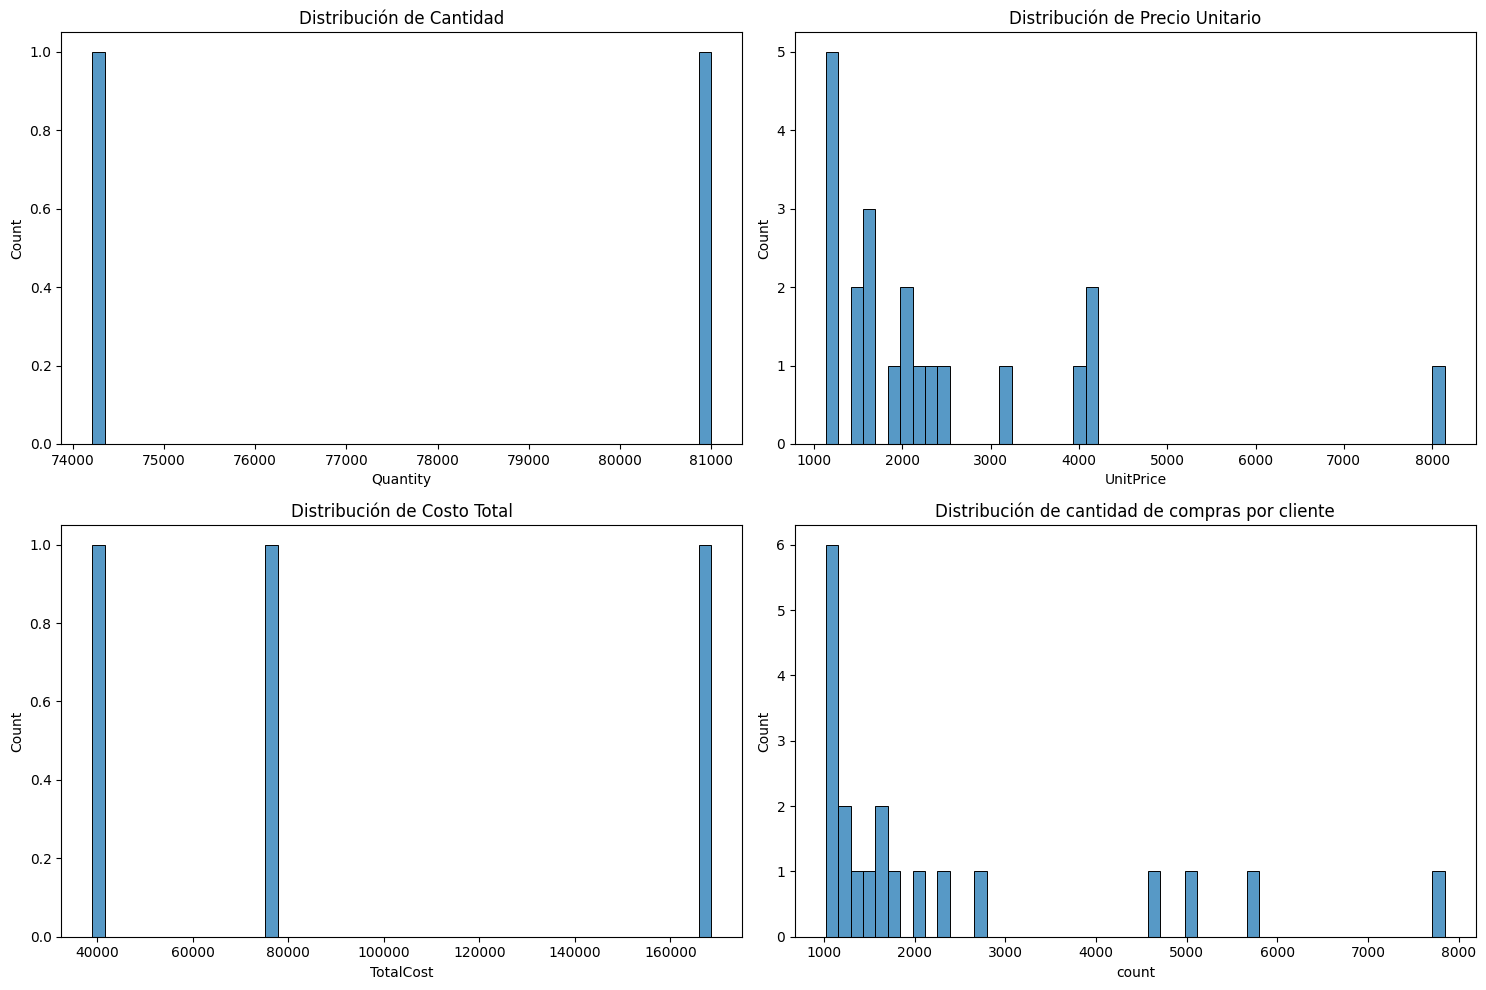

In [1519]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(df.loc[df['Quantity'] > 10000, 'Quantity'], bins=50)
plt.title('Distribución de Cantidad')
plt.subplot(2, 2, 2)
sns.histplot(df.loc[df['UnitPrice'] > 1000, 'UnitPrice'], bins=50)
plt.title('Distribución de Precio Unitario')
plt.subplot(2, 2, 3)
sns.histplot(df.loc[df['TotalCost'] > 10000, 'TotalCost'], bins=50)
plt.title('Distribución de Costo Total')
plt.subplot(2, 2, 4)

vc = df['CustomerID'].value_counts()
sns.histplot(vc[vc > 1000], bins=50)
plt.title('Distribución de cantidad de compras por cliente')
plt.tight_layout()
plt.show()


## Analisis de la variable temporal

Se observa estacionalidad

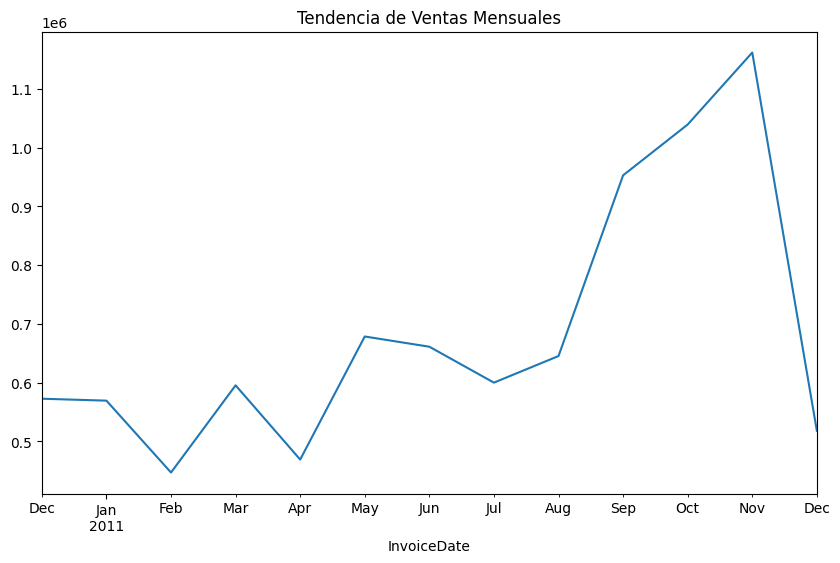

In [1520]:
plt.figure(figsize=(10, 6))
df.set_index('InvoiceDate')['TotalCost'].resample('M').sum().plot() # Suma de ventas por mes
plt.title('Tendencia de Ventas Mensuales')
plt.show()

## Correlaciones (usando un subconjunto para mejorar el rendimiento)

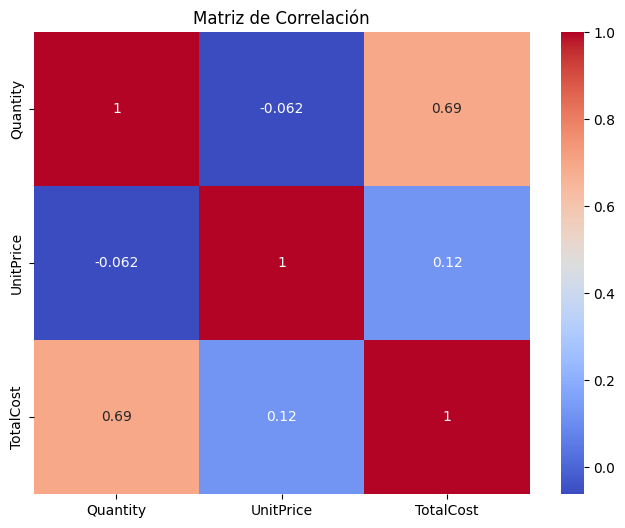

In [1521]:
df_sample = df.sample(frac=0.1, random_state=42) # Tomamos una muestra para el análisis de correlación
correlation_matrix = df_sample[['Quantity', 'UnitPrice', 'TotalCost']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

## Boxplots para detectar outliers

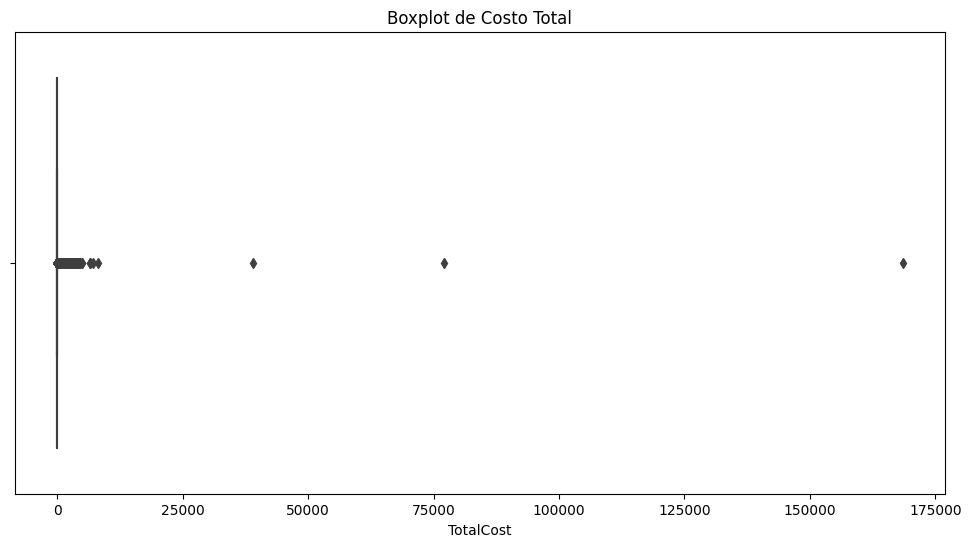

In [1522]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['TotalCost'])
plt.title('Boxplot de Costo Total')
plt.show()

# Limpieza y feature engeneering

In [1523]:
# Remover compras retornadas
# Extraer filas en las que invoice empieza con 'C'
cancelled_orders = df[df['InvoiceNo'].astype(str).str.startswith("C")]

# Crear dataframe temporal
cancelled_orders['Quantity'] = -cancelled_orders['Quantity']

# Unir el dataframe original con el temporal en las columnas que queremos
merged_data = pd.merge(df, cancelled_orders[['CustomerID', 'StockCode', 'Quantity', 'UnitPrice']], 
                       on=['CustomerID', 'StockCode', 'Quantity', 'UnitPrice'], 
                       how='left', indicator=True)

# Filtar filas en las que el merge encontro un match, y filtar las compras retornadas
df = merged_data[(merged_data['_merge'] == 'left_only') & (~merged_data['InvoiceNo'].astype(str).str.startswith("C"))]

# Drop columna de indicador
df = df.drop(columns=['_merge'])

# Seleccionar features relevantes y calcular ventas totales
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country']
data = df[features]
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])

# Remover columnas con CustomerID faltante ya que no nos daran informacion del comportamiento de los consumidores
data = data[data['CustomerID'].notna()]
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)
data.head()

,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,Country,TotalSales
0,17850,536365,2010-12-01 08:26:00,6,2.55,United Kingdom,15.30
1,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
2,17850,536365,2010-12-01 08:26:00,8,2.75,United Kingdom,22.00
3,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
4,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34


## Crear RFM-T

Usaremos una funcion de pymc-marketing para crear un dataframe en el formato RFM-T, que hace referencia a recency, frequency, monetary, y tenure

In [1524]:
data_summary_rfm = clv.utils.clv_summary(data, 'CustomerID', 'InvoiceDate', 'TotalSales')
data_summary_rfm = data_summary_rfm.rename(columns={'CustomerID': 'customer_id'})
data_summary_rfm.index = data_summary_rfm['customer_id']
data_summary_rfm.head()

/usr/local/lib/python3.10/dist-packages/pymc_marketing/clv/utils.py:268: UserWarning: clv_summary was renamed to rfm_summary
  warnings.warn("clv_summary was renamed to rfm_summary", UserWarning, stacklevel=1)


,customer_id,frequency,recency,T,monetary_value
customer_id,,,,,
12346,12346,0.0,0.0,325.0,0.000000
12347,12347,6.0,365.0,367.0,599.701667
12348,12348,3.0,283.0,358.0,301.480000
12349,12349,0.0,0.0,18.0,0.000000
12350,12350,0.0,0.0,310.0,0.000000


# Modelado

## Modelo BG/NBD

In [1525]:
bgm = clv.BetaGeoModel(
    data = data_summary_rfm,
)
bgm.build_model()

bgm.fit()
bgm.fit_summary()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.006,0.017,0.000,0.014,0.000,0.000,852.0,681.0,1.01
alpha,68.892,2.597,64.106,73.811,0.077,0.055,1129.0,1199.0,1.00
b,5.297,46.892,0.998,7.965,1.512,1.069,1822.0,967.0,1.00
kappa_dropout,5.303,46.905,1.000,7.979,1.512,1.070,1827.0,1021.0,1.00
phi_dropout,0.002,0.002,0.000,0.006,0.000,0.000,877.0,639.0,1.00
r,0.828,0.027,0.777,0.876,0.001,0.001,1156.0,1156.0,1.00


<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

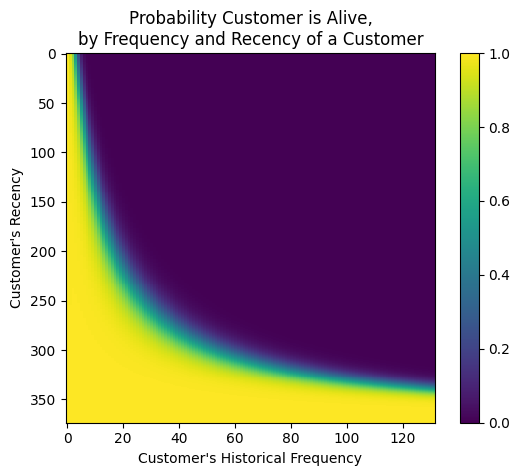

In [1526]:
clv.plot_probability_alive_matrix(bgm)

## Predecir futuras transacciones de cada consumidor

In [1527]:
num_purchases = bgm.expected_num_purchases(
    customer_id=data_summary_rfm["customer_id"],
    t=365,
    frequency=data_summary_rfm["frequency"],
    recency=data_summary_rfm["recency"],
    T=data_summary_rfm["T"]
)

sdata = data_summary_rfm.copy()
sdata["expected_purchases"] = num_purchases.mean(("chain", "draw")).values
sdata.sort_values(by="expected_purchases").tail(4)

,customer_id,frequency,recency,T,monetary_value,expected_purchases
customer_id,,,,,,
15311,15311,89.0,373.0,373.0,677.729438,74.069437
17841,17841,111.0,372.0,373.0,364.452162,92.208309
12748,12748,112.0,373.0,373.0,301.024821,93.034071
14911,14911,131.0,372.0,373.0,1093.661679,108.698868


## Modelo Gamma-Gamma

In [1528]:
nonzero_data = data_summary_rfm.query("frequency>0")
dataset = pd.DataFrame({
    'customer_id': nonzero_data.customer_id,
    'monetary_value': nonzero_data["monetary_value"],
    'frequency': nonzero_data["frequency"],
})
gg = clv.GammaGammaModel(
    data = dataset
)
gg.build_model()
gg.fit();

expected_spend = gg.expected_customer_spend(
    data=data_summary_rfm
)

Output()

## Valor medio de los pedidos esperado por consumidor

Text(0.5, 0, 'Valor medio de los pedidos esperado')

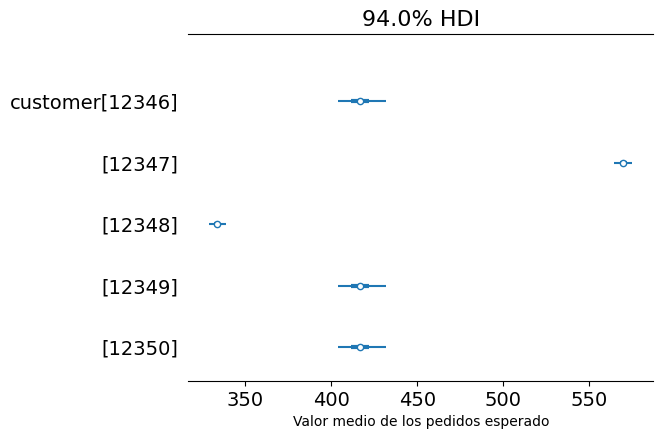

In [1529]:
labeller = MapLabeller(var_name_map={"x": "customer"})
az.plot_forest(expected_spend.isel(customer_id=(range(5))), combined=True, labeller=labeller)
plt.xlabel("Valor medio de los pedidos esperado")

## Estimar Consumer Lifetime Value

In [1530]:
clv_estimate = gg.expected_customer_lifetime_value(
    transaction_model=bgm,
    data=data_summary_rfm,
    future_t=12, # 12 meses
    discount_rate=0.01,
    time_unit="D",
)

clv_df = az.summary(clv_estimate, kind="stats").reset_index()

clv_df['customer_id'] = clv_df['index'].str.extract('(\d+)')[0]

clv_df = clv_df[['customer_id', 'mean', 'hdi_3%', 'hdi_97%']]
clv_df.rename(columns={'mean' : 'clv_estimate', 'hdi_3%': 'clv_estimate_hdi_3%', 'hdi_97%': 'clv_estimate_hdi_97%'}, inplace=True)

monetary_values = data_summary_rfm.set_index('customer_id').loc[clv_df['customer_id'], 'monetary_value']
clv_df['monetary_value'] = monetary_values.values

# Estimacion de CLV por pais

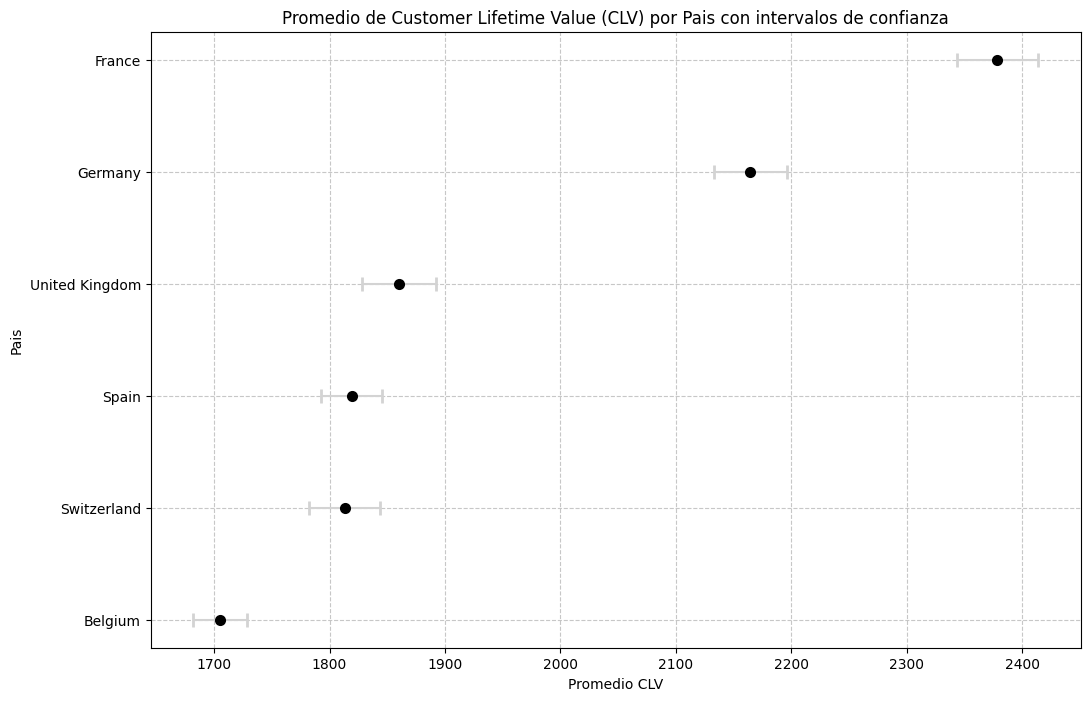

In [1531]:
# Calcular ventas totales por transaccion
data['TotalSales'] = data['Quantity'] * data['UnitPrice']
customer_sales = data.groupby('CustomerID').agg({
    'TotalSales': sum,
    'Country': 'first'  # Asumimos que cada cliente solo compra en un pais
})


customer_countries = customer_sales.reset_index()[['CustomerID', 'Country']]

clv_with_country = pd.merge(clv_df, customer_countries, left_on='customer_id', right_on='CustomerID', how='left')

average_clv_by_country = clv_with_country.groupby('Country')['clv_estimate'].mean()

customer_count_by_country = data.groupby('Country')['CustomerID'].nunique()

country_clv_summary = pd.DataFrame({
    'AverageCLV': average_clv_by_country,
    'CustomerCount': customer_count_by_country,
})
# Calcular limites superiores e inferiores
average_clv_lower_by_country = clv_with_country.groupby('Country')['clv_estimate_hdi_3%'].mean()
average_clv_upper_by_country = clv_with_country.groupby('Country')['clv_estimate_hdi_97%'].mean()

# Agregar promedios al dataframe country_clv_summary
country_clv_summary['AverageCLVLower'] = average_clv_lower_by_country
country_clv_summary['AverageCLVUpper'] = average_clv_upper_by_country

# Filtar paises con mas de 20 clientes
filtered_countries = country_clv_summary[country_clv_summary['CustomerCount'] >= 20]

# Sortear en orden descendente por numero de clientes
sorted_countries = filtered_countries.sort_values(by='AverageCLV', ascending=False)

# Preparar intervalos de confianza
lower_error = sorted_countries['AverageCLV'] - sorted_countries['AverageCLVLower']
upper_error = sorted_countries['AverageCLVUpper'] - sorted_countries['AverageCLV']
asymmetric_error = [lower_error, upper_error]

plt.figure(figsize=(12,8))

# Crear plot representando el promedio de CLV con intervalos de confianza
plt.errorbar(x=sorted_countries['AverageCLV'], y=sorted_countries.index.tolist(), 
             xerr=asymmetric_error, fmt='o', color='black', ecolor='lightgray', capsize=5, markeredgewidth=2)

# Titulo y labels
plt.xlabel('Promedio CLV')
plt.ylabel('Pais')
plt.title('Promedio de Customer Lifetime Value (CLV) por Pais con intervalos de confianza')

# Ajustar axis vertical para mostrar paises en orden descendente
plt.gca().invert_yaxis()

# Grid lines
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

# Recomendaciones
Podemos obervar como los clientes en Francia tienden a tener un CLV alto. Por otro lado, los clientes en Belgica tienden a tener un CLV bajo. Dado esto recomiendo aumentar el presupuesto en marketing para adquirir consumidores en Francia y disminuirlo en Belgica

